In [161]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt

# Условие задачи

Входные данные - персональные данные о некоторых клиентах оператора связи, информацию об их тарифах и договорах.

Задача - научиться прогнозировать отток клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Оглавление

* [Исследовательский анализ данных](#Исследовательский-анализ-данных)
    * [Договоры](#Договоры)
    * [Персональные данные клиента](#Персональные-данные-клиента)
    * [Интернет услуги](#Интернет-услуги)
    * [Услуги телефонии](#Услуги-телефонии)
    * [Соединение в таблицу признаков](#Соединение-в-таблицу-признаков)  
* [Список уточняющих вопросов](#Список-уточняющих-вопросов)
* [План решения задачи](#План-решения-задачи)
* [Тестирование моделей](#Тестирование-моделей)
    * [Разделение на тестовую и обучающую выборки](#Разделение-на-тестовую-и-обучающую-выборки)
    * [Константная модель](#Константная-модель)
    * [Логистическая регрессия](#Логистическая-регрессия)
    * [Дерево решений](#Дерево-решений)
    * [Случайный лес](#Случайный-лес)
    * [CatBoost](#CatBoost)
    * [VotingClassifier](#VotingClassifier)
* [Проверка лучшей модели на тестовой выборке](#Проверка-лучшей-модели-на-тестовой-выборке)
* [Общие выводы](#Общие-выводы)
* [Отчет](#Отчет)

# Исследовательский анализ данных

## Договоры

In [162]:
contract = pd.read_csv('contract.csv')

In [163]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [164]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,0181-RITDD,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [165]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [166]:
_underscorer1 = re.compile(r'(.)([A-Z][a-z]+)')
_underscorer2 = re.compile('([a-z0-9])([A-Z])')

def to_snake_case(columns):
    """
    Function for casting DataFrame columns names from camelCase to snake_case
    
    Parameters
    columns (array-like): Array of CamelCased columns names
    
    Returns
    (list): List of snake_cased columns names
    """
    
    return list(map(lambda string: _underscorer2.sub(r'\1_\2', _underscorer1.sub(r'\1_\2', string)).lower(), columns))

In [167]:
# columns name from CamelCase to snake_case
contract.columns = to_snake_case(contract.columns)

contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

### Начало действия договора

In [168]:
contract['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [169]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

In [170]:
contract['begin_date'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object

### Окончание действия договора

In [171]:
contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [172]:
# replacing contract end date equals "No" with NaN to cast feature to datetime
contract.loc[contract['end_date'] == 'No', 'end_date'] = np.NaN

In [173]:
contract['end_date'] = pd.to_datetime(contract['end_date'])

In [174]:
contract['end_date'].describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630464
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object

### Переодичность оплаты

In [175]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [176]:
contract['type'] = contract['type'].astype('category')

### Безбумажный биллинг

In [177]:
contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

In [178]:
contract['paperless_billing'] = contract['paperless_billing'].astype('category')

### Метод оплаты

In [179]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

In [180]:
contract['payment_method'] = contract['payment_method'].astype('category')

### Ежемесячные платеж

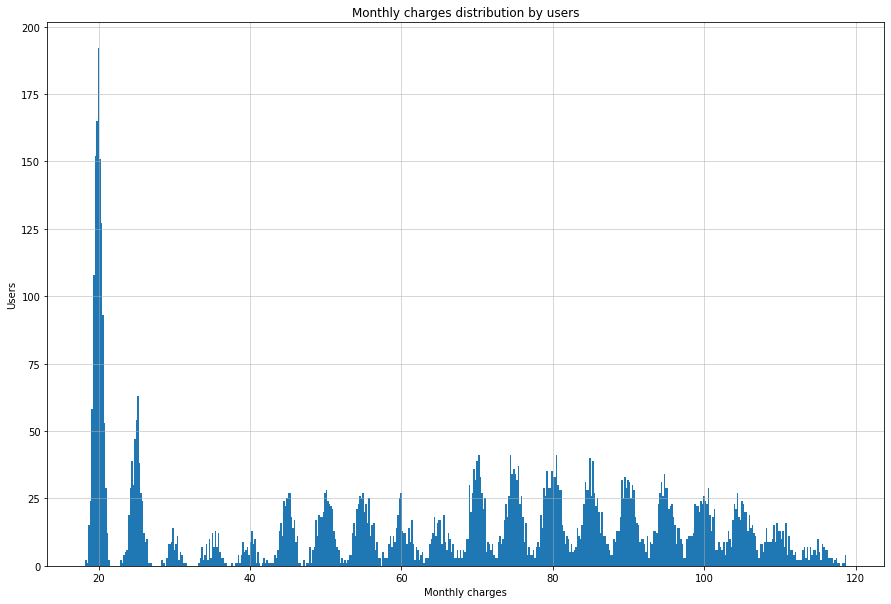

In [181]:
contract['monthly_charges'].hist(bins=500, figsize=(15, 10))
plt.xlabel('Monthly charges')
plt.ylabel('Users')
plt.grid(linewidth=0.5)
plt.title('Monthly charges distribution by users')
plt.show()

### Общие расходы

In [182]:
contract['total_charges'].value_counts()

20.2       11
           11
19.75       9
19.65       8
20.05       8
           ..
2058.5      1
2215.45     1
66.95       1
552.9       1
754         1
Name: total_charges, Length: 6531, dtype: int64

In [183]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


In [184]:
# replacing anomalies with monthly charges
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract.loc[contract['total_charges'] == ' ', 'monthly_charges']

In [185]:
contract['total_charges'] = contract['total_charges'].astype('float')

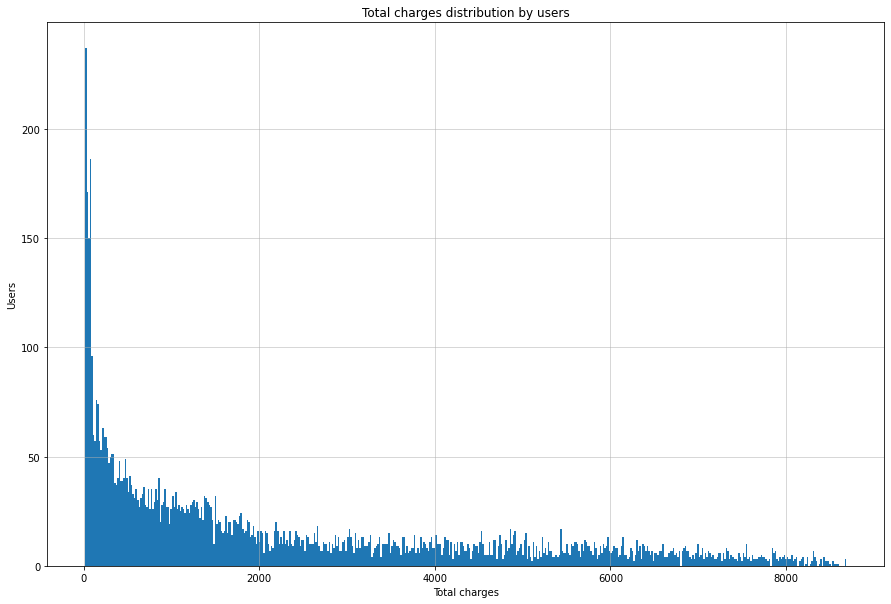

In [186]:
contract['total_charges'].hist(bins=500, figsize=(15, 10))
plt.xlabel('Total charges')
plt.ylabel('Users')
plt.grid(linewidth=0.5)
plt.title('Total charges distribution by users')
plt.show()

In [187]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: category(3), datetime64[ns](2), float64(2), object(1)
memory usage: 296.3+ KB


### Целевой признак

In [188]:
contract['end_date'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: end_date, dtype: int64

In [189]:
# extracting target feature
contract['exited'] = (~contract['end_date'].isnull()).astype(int)

In [190]:
contract['exited'].value_counts()

0    5174
1    1869
Name: exited, dtype: int64

In [191]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Добавление признака "длительность контракта на 01.02.2020"

In [192]:
def get_contract_duration(row):
    """
    Function for duration of the contract as of 01.02.2020 calculation
    
    Parameters
    row (pd.DataFrame row): DataFrame row
    
    Returns
    (int): Duration of the contract as of 01.02.2020
    """
    
    if pd.isnull(row['end_date']):
        return int((pd.to_datetime('2020-02-01') - row['begin_date'])  / np.timedelta64(1, 'M'))
    else:
        return int((row['end_date'] - row['begin_date']) / np.timedelta64(1, 'M'))

In [193]:
contract['duration'] = contract.apply(get_contract_duration, axis=1)

In [194]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


In [195]:
contract.describe(include='all', datetime_is_numeric=True)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration
count,7043,7043,1869,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
unique,7043,NaN,NaN,3,2,4,NaN,NaN,NaN,NaN
top,0181-RITDD,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,3875,4171,2365,NaN,NaN,NaN,NaN
mean,NaN,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630464,NaN,NaN,NaN,64.761692,2279.798992,0.265370,32.166832
min,NaN,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,18.250000,18.800000,0.000000,0.000000
25%,NaN,2015-06-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,35.500000,398.550000,0.000000,8.000000
50%,NaN,2017-09-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,70.350000,1394.550000,0.000000,29.000000
75%,NaN,2019-04-01 00:00:00,2019-12-01 00:00:00,NaN,NaN,NaN,89.850000,3786.600000,1.000000,55.000000
max,NaN,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,118.750000,8684.800000,1.000000,71.000000


### Выводы

Файл `contracts.csv` состоит из 8 столбцов (1 с числами с плавающей точкой и 7 с объектами) и 7043 записей. Столбцы, судя по их названию и содержанию содержат следующую информацию:
- customer_id - ID пользователя;
- begin_date - дата начала действия контракта. Преобразован к datetime;
- end_date - дата окончания действия контракта. Преобразован к datetime;
- type - переодичность оплаты (раз в месяц/год/2 года). Преобразован к категориальному типу;
- paperless_billing - использование электронных чеков. Преобразован к категориальному типу;
- payment_method - способ оплаты (физический или электронный чек, банковский перевод или оплата с карты). Преобразован к категориальному типу;
- monthly_charges - размер ежемесячного платежа;
- total_charges - сумма, списанная с пользователя за все время. Удалены 10 аномалий, столбец приведен к типу float.

В данных был выделен целевой признак - наличие даты окончания действия контракта. Если таковая имеется, значит пользователь ушел от оператора.

Также был добавлен признак "длительность контракта на 01.02.2020", который содержит количество месяцев с начала действия контракта до даты его окончания, либо до 01.02.2020, если пользователь не ушел от оператора.

На гистограмме распределения пользователей по ежемесячному платежу видно, что данные имеют распределения, близкие к нормальному, со средними около каждого значения, кратного 5.

## Персональные данные клиента

In [196]:
personal = pd.read_csv('personal.csv')

In [197]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [198]:
personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,0181-RITDD,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [199]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [200]:
# columns name from CamelCase to snake_case
personal.columns = to_snake_case(personal.columns)

personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

### Пол

In [201]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

### Пенсионер

In [202]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

### Наличие партнера

In [203]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

### Наличие иждивенцев

In [204]:
personal['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

In [205]:
for column in personal.columns[1:]:
    personal[column] = personal[column].astype('category')

In [206]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_citizen  7043 non-null   category
 3   partner         7043 non-null   category
 4   dependents      7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.0+ KB


In [207]:
personal.describe(include='all')

,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,0181-RITDD,Male,0,No,No
freq,1,3555,5901,3641,4933


### Выводы

Файл `personal.csv` состоит из 5 столбцов (1 целочисленный и 4 с объектами) и 7043 записей. Столбцы, судя по их названию и содержанию содержат следующую информацию:
- customer_id - ID пользователя;
- gender - пол пользователя;
- senior_citizen - пенсионер ли пользователь;
- partner - состоит ли пользователь в отношениях;
- dependents - наличие иждивенцев.

Все столбцы, кроме ID пользователя, преобразованы к категориальному типу.

## Интернет услуги

In [208]:
internet = pd.read_csv('internet.csv')

In [209]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [210]:
internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0181-RITDD,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [211]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [212]:
# columns name from CamelCase to snake_case
internet.columns = to_snake_case(internet.columns)

internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

### Тип подключения

In [213]:
internet['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

### Блокировка небезопасных сайтов

In [214]:
internet['online_security'].value_counts()

No     3498
Yes    2019
Name: online_security, dtype: int64

### Облачное хранилище файлов для резервного копирования данных

In [215]:
internet['online_backup'].value_counts()

No     3088
Yes    2429
Name: online_backup, dtype: int64

### Антивирус

In [216]:
internet['device_protection'].value_counts()

No     3095
Yes    2422
Name: device_protection, dtype: int64

### Выделенная линия технической поддержки

In [217]:
internet['tech_support'].value_counts()

No     3473
Yes    2044
Name: tech_support, dtype: int64

### Стриминговое телевидение

In [218]:
internet['streaming_tv'].value_counts()

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

### Каталог фильмов

In [219]:
internet['streaming_movies'].value_counts()

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

In [220]:
for column in internet.columns[1:]:
    internet[column] = internet[column].astype('category')

In [221]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   category
 2   online_security    5517 non-null   category
 3   online_backup      5517 non-null   category
 4   device_protection  5517 non-null   category
 5   tech_support       5517 non-null   category
 6   streaming_tv       5517 non-null   category
 7   streaming_movies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.6+ KB


In [222]:
internet.describe(include='all')

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0181-RITDD,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### Выводы

Файл `internet.csv` состоит из 8 столбцов с объектами и 5517 записей (не все пользователи пользуются интернет-услугами). Столбцы, судя по их названию и содержанию содержат следующую информацию:
- customer_id - ID пользователя;
- internet_service - тип подключения (DSL или оптоволокно);
- online_security - подключена ли услуга блокировки небезопасных сайтов;
- online_backup - подключена ли облачное хранилище файлов для резервного копирования данных;
- device_protection - подключен ли антивирус;
- tech_support - подключена ли выделенная линия технической поддержки;
- streaming_tv - подключено ли стриминговое телевидение;
- streaming_movies - подключен ли каталог фильмов.

Все столбцы, кроме ID пользователя, преобразованы к категориальному типу.

## Услуги телефонии

In [223]:
phone = pd.read_csv('phone.csv')

In [224]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [225]:
phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0181-RITDD,No
freq,1,3390


In [226]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [227]:
# columns name from CamelCase to snake_case
phone.columns = to_snake_case(phone.columns)

phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

### Несколько линий

In [228]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [229]:
phone['multiple_lines'] = phone['multiple_lines'].astype('category')

In [230]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     6361 non-null   object  
 1   multiple_lines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.1+ KB


In [231]:
phone.describe(include='all')

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,0181-RITDD,No
freq,1,3390


### Выводы

Файл `phone.csv` состоит из 2 столбцов с объектами и 6361 записи (не все пользователи пользуются услугами телефонии, но таких больше, чем пользователей, с подключенными интернет-услугами). Столбцы, судя по их названию и содержанию содержат следующую информацию:
- customer_id - ID пользователя;
- multiple_lines - использование абонентом нескольких телефонных линий. Преобразован к категориальному типу.

## Соединение в таблицу признаков

In [232]:
data = contract.merge(right=personal, on='customer_id', validate='one_to_one')
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,Male,0,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,Female,0,No,No


In [233]:
data = data.merge(right=internet, how='left', on='customer_id')
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,...,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,...,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,...,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,...,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,0,No,No,Fiber optic,No,No,No,No,No,No


In [234]:
data = data.merge(right=phone, how='left', on='customer_id')
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,No,No,Fiber optic,No,No,No,No,No,No,No


### Заполнение пропусков

In [235]:
# filling missing values in columns containing information about internet services
for column in internet.columns[1:]:
    if column == 'internet_service':
        data[column].cat.add_categories('No', inplace=True)
    
    data[column].fillna('No', inplace=True)

In [236]:
# filling missing values in columns containing information about telephony services
data['multiple_lines'].cat.add_categories('No Phone', inplace=True)
data['multiple_lines'].fillna('No Phone', inplace=True)

In [237]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,...,Yes,No,DSL,No,Yes,No,No,No,No,No Phone
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No Phone
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   exited             7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  gender             7043 non-null   category      
 11  senior_citizen     7043 non-null   category      
 12  partner            7043 non-null   category      
 13  dependents         7043 non-null   category      
 14  internet

### Выделение признаков и целевого признака

In [239]:
features = data[data.columns[3:]].drop(columns=['exited'])
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   duration           7043 non-null   int64   
 6   gender             7043 non-null   category
 7   senior_citizen     7043 non-null   category
 8   partner            7043 non-null   category
 9   dependents         7043 non-null   category
 10  internet_service   7043 non-null   category
 11  online_security    7043 non-null   category
 12  online_backup      7043 non-null   category
 13  device_protection  7043 non-null   category
 14  tech_support       7043 non-null   category
 15  streaming_tv       7043 non-null   category
 16  stream

In [240]:
target = data['exited']
target.shape

(7043,)

### Выводы

Все данные были собраны в одном DataFrame для удобства использования. Пропуски в данных были заполнены следующим образом:
- для столбцов, описывающих подключенные интернет-услуги, пропуски были заполнены как отсутствие услуги;
- для столбца, описывающего использование абонентом нескольких линий, пропуски также были заполнены как отсутствие услуги - введена новая категория "No Phone".

Объекты с пропусками в общих затратах пользователя были удалены т.к. они не подлежат заполнению и составляют незначительное количество от объема выборки.

В данных были выделены признаки и целевой признак.

# Список уточняющих вопросов

1. Верно ли, что ушедшим считается пользователь с датой в столбце end_date?
2. Необходимо спрогнозировать только бинарный показатель оттока (уйдет пользователь или нет) или бизнесу также требуется вероятность ухода, а также, возможно, какие-то пороговые значения вероятностей для разной степени скидок?
3. С помощью какой метрики/метрик определять качество моделей?
4. Есть ли какие-либо требования к используемым моделям?
5. Какие требования к валидации и тестированию моделей?
4. В чем заключается дополнительная задача?
5. Какие требования и рекомендации предъявляются к отчету?
6. Известно ли, что означает пробел в столбце total_charges? Возможно, это ошибка при выгрузке данных, которую можно устранить?

# План решения задачи

1. Анализ ответов на вопросы и результатов встречи с тимлидом. Возможны корректировка и дополнение стадий EDA и feature engineering;
2. Построение пайплайнов для разных моделей (OHE, нормализация, кросс-валидация) и подбор оптимальных значений гиперпараметров моделей;
3. Анализ результатов подбора гиперпараметров - оценка значимости признаков и значений целевой метрики для разных моделей. Возможны корректировки признаков, например, удаление наименее значимых признаков или понижение размерности;
4. Оценка качества лучшей модели на тестовой выборке;
5. Составление отчета по проделанной работе и полученными результатам.

Пункты 2 и 3 повторяются итеративно пока значение целевой метрики значимо улучшается. План может быть скорректирован в результате анализа ответов на вопросы и результатов встречи с тимлидом.

# Тестирование моделей

In [256]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier

## Разделение на тестовую и обучающую выборки

In [242]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [243]:
# data preprocessing - Standard Scale for numeric features and OHE for categorical features
ct = ColumnTransformer([
    ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('categorical', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))
])

## Константная модель

In [258]:
l = y_train.shape[0] / 5

mean_roc_auc = 0
mean_accuracy = 0

for i in range(5):
    fold = y_train[int(i * l):int((i + 1) * l)]

    mean_roc_auc += roc_auc_score(y_true=fold, y_score=[fold.value_counts().argmax()] * fold.shape[0]) #ошибка
    mean_accuracy += accuracy_score(y_true=fold, y_pred=[fold.value_counts().argmax()] * fold.shape[0]) #ошибка
    
print('ROC AUC with constant model - {:.3f}, accuracy - {:.3f}'.format(mean_roc_auc / 5, mean_accuracy / 5))

ROC AUC with constant model - 0.500, accuracy - 0.734


## Логистическая регрессия

In [118]:
pipe_logreg = Pipeline([
    ('transformer', ct),
    ('regression', LogisticRegression(max_iter=200, class_weight='balanced', random_state=42, n_jobs=1))
])

In [86]:
params_logreg = {
    'regression__C': np.geomspace(1e-4, 1000, 1000)
}

In [120]:
search_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=params_logreg,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [88]:
search_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('regression',
                                        Lo...
       7.35981448e+02, 7.47952252e+02, 7.60117762e+02, 7.72481145e+02,
       7.85045620e+02, 7.97814457e+02, 8.10790981e+02, 8.23978568e+02,
       

In [89]:
(
    pd.DataFrame(search_logreg.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_regression__C', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_regression__C,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
886,161.513,0.843812,0.848024,0.741926,0.746894
885,158.928,0.843812,0.848024,0.741926,0.746894
830,65.4359,0.843811,0.848023,0.741748,0.747027
882,151.419,0.843810,0.848022,0.741926,0.746938
884,156.385,0.843809,0.848025,0.741926,0.746894
...,...,...,...,...,...
4,0.000106666,0.822852,0.823648,0.733761,0.733626
3,0.000104959,0.822795,0.823606,0.733050,0.733493
2,0.000103279,0.822757,0.823561,0.732695,0.733537
1,0.000101627,0.822721,0.823514,0.732518,0.733271


In [90]:
# Best parameters
search_logreg.best_params_

{'regression__C': 161.51326935030897}

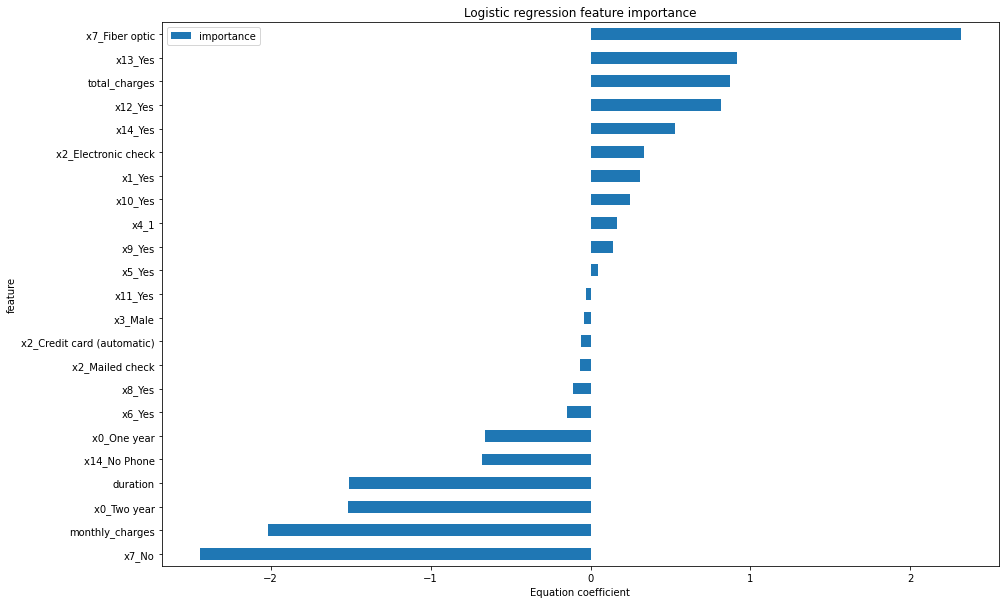

In [124]:
fi = pd.DataFrame({'importance': search_logreg.best_estimator_['regression'].coef_[0], 'feature': search_logreg.best_estimator_.named_steps.transformer.transformers_[0][2] + list(search_logreg.best_estimator_.named_steps.transformer.named_transformers_.categorical.get_feature_names())}).sort_values('importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.xlabel('Equation coefficient')
plt.title('Logistic regression feature importance')
plt.show()

## Дерево решений

In [125]:
pipe_tree = Pipeline([
    ('transformer', ct),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

### Часть 1

In [95]:
params_tree = {
    'tree__max_depth': np.arange(1, 12, 2),
    'tree__min_samples_split': np.arange(2, 503, 25),
    'tree__min_samples_leaf': np.arange(1, 102, 5)
}

In [96]:
search_tree = GridSearchCV(
    pipe_tree,
    param_grid=params_tree,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [99]:
search_tree.fit(X_train, y_train)

Fitting 5 folds for each of 2646 candidates, totalling 13230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('tree',
                                        Decision...
             n_jobs=-1,
             param_grid={'tree__max_depth': array([ 1,  3,  5,  7,  9, 11]),
                         'tree__min_samples_leaf

In [102]:
(
    pd.DataFrame(search_tree.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_tree__max_depth', 'param_tree__min_samples_split', 'param_tree__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_tree__max_depth,param_tree__min_samples_split,param_tree__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
2422,11,177,51,0.845653,0.865514,0.745651,0.758876
1981,9,177,51,0.845653,0.865514,0.745651,0.758876
1960,9,177,46,0.845071,0.865876,0.745829,0.761006
2401,11,177,46,0.845071,0.865876,0.745829,0.761006
1520,7,202,46,0.844789,0.861449,0.739264,0.751243
...,...,...,...,...,...,...,...
297,1,77,71,0.644507,0.644501,0.489710,0.489706
298,1,102,71,0.644507,0.644501,0.489710,0.489706
299,1,127,71,0.644507,0.644501,0.489710,0.489706
300,1,152,71,0.644507,0.644501,0.489710,0.489706


### Часть 2

In [103]:
params_tree_2 = {
    'tree__max_depth': np.arange(7, 16, 2),
    'tree__min_samples_split': np.arange(150, 251, 5),
    'tree__min_samples_leaf': np.arange(25, 77, 3)
}

In [104]:
search_tree_2 = GridSearchCV(
    pipe_tree,
    param_grid=params_tree_2,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [105]:
search_tree_2.fit(X_train, y_train)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('tree',
                                        Decision...
             n_jobs=-1,
             param_grid={'tree__max_depth': array([ 7,  9, 11, 13, 15]),
                         'tree__min_samples_leaf': a

In [111]:
(
    pd.DataFrame(search_tree_2.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_tree__max_depth', 'param_tree__min_samples_split', 'param_tree__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_tree__max_depth,param_tree__min_samples_split,param_tree__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
869,11,190,40,0.845267,0.865565,0.743167,0.756124
491,9,190,40,0.845267,0.865565,0.743167,0.756124
1247,13,190,40,0.845267,0.865565,0.743167,0.756124
1625,15,190,40,0.845267,0.865565,0.743167,0.756124
1226,13,190,37,0.845239,0.865661,0.740505,0.753506
...,...,...,...,...,...,...,...
1133,11,250,76,0.833569,0.850869,0.725599,0.736243
377,7,250,76,0.833569,0.850869,0.725599,0.736243
1511,13,250,76,0.833569,0.850869,0.725599,0.736243
755,9,250,76,0.833569,0.850869,0.725599,0.736243


### Часть 3

In [121]:
params_tree_3 = {
    'tree__max_depth': np.arange(8, 14),
    'tree__min_samples_split': np.arange(170, 201),
    'tree__min_samples_leaf': np.arange(35, 61)
}

In [127]:
search_tree_3 = GridSearchCV(
    pipe_tree,
    param_grid=params_tree_3,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [123]:
search_tree_3.fit(X_train, y_train)

Fitting 5 folds for each of 4836 candidates, totalling 24180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('tree',
                                        Decision...
                         'tree__min_samples_leaf': array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 

In [124]:
(
    pd.DataFrame(search_tree_3.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_tree__max_depth', 'param_tree__min_samples_split', 'param_tree__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_tree__max_depth,param_tree__min_samples_split,param_tree__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
1319,9,187,51,0.845899,0.864887,0.743699,0.755503
2125,10,187,51,0.845899,0.864887,0.743699,0.755503
3738,12,188,51,0.845899,0.864887,0.743699,0.755503
3737,12,187,51,0.845899,0.864887,0.743699,0.755503
4543,13,187,51,0.845899,0.864887,0.743699,0.755503
...,...,...,...,...,...,...,...
4712,13,170,57,0.839376,0.862487,0.738908,0.753905
745,8,171,59,0.839342,0.861672,0.739263,0.755636
744,8,170,59,0.839342,0.861672,0.739263,0.755636
753,8,179,59,0.839341,0.861455,0.736068,0.753905


In [125]:
# Best parameters
search_tree_3.best_params_

{'tree__max_depth': 9,
 'tree__min_samples_leaf': 51,
 'tree__min_samples_split': 187}

In [130]:
cat_columns_ohe = list(search_tree_3.best_estimator_.named_steps.transformer.named_transformers_.categorical.get_feature_names())
cat_columns = X_train.select_dtypes('category').columns

cat_columns_ohe_names = []

for column in cat_columns_ohe:
    cat_columns_ohe_names.append(cat_columns[int(column.split('_')[0][1:])] + '_' + column.split('_')[1])

cat_columns_ohe_names

['type_One year',
 'type_Two year',
 'paperless_billing_Yes',
 'payment_method_Credit card (automatic)',
 'payment_method_Electronic check',
 'payment_method_Mailed check',
 'gender_Male',
 'senior_citizen_1',
 'partner_Yes',
 'dependents_Yes',
 'internet_service_Fiber optic',
 'internet_service_No',
 'online_security_Yes',
 'online_backup_Yes',
 'device_protection_Yes',
 'tech_support_Yes',
 'streaming_tv_Yes',
 'streaming_movies_Yes',
 'multiple_lines_No Phone',
 'multiple_lines_Yes']

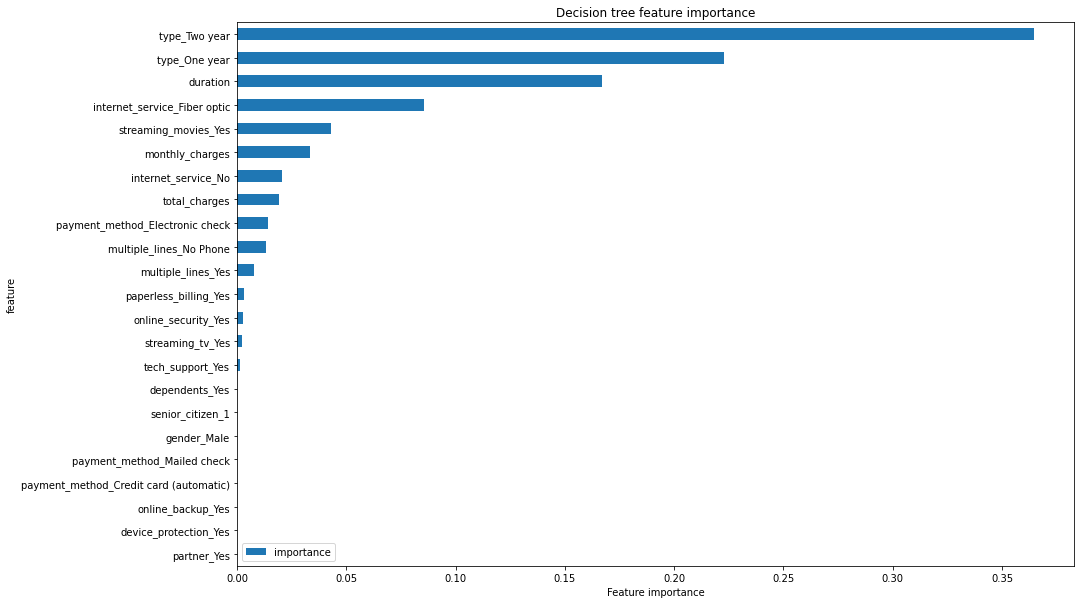

In [131]:
fi = pd.DataFrame({'importance': search_tree_3.best_estimator_['tree'].feature_importances_, 'feature': search_tree_3.best_estimator_.named_steps.transformer.transformers_[0][2] + cat_columns_ohe_names}).sort_values('importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.xlabel('Feature importance')
plt.title('Decision tree feature importance')
plt.show()

### Часть 4

In [155]:
params_tree_4 = {
    'tree__max_depth': np.arange(8, 14),
    'tree__min_samples_split': np.arange(170, 201),
    'tree__min_samples_leaf': np.arange(35, 61)
}

In [156]:
search_tree_4 = GridSearchCV(
    pipe_tree,
    param_grid=params_tree_4,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [157]:
search_tree_4.fit(X_train.drop(columns=['partner', 'device_protection', 'online_backup', 'gender', 'senior_citizen', 'dependents']), y_train)

Fitting 5 folds for each of 4836 candidates, totalling 24180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('tree',
                                        Decision...
                         'tree__min_samples_leaf': array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 

In [158]:
(
    pd.DataFrame(search_tree_4.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_tree__max_depth', 'param_tree__min_samples_split', 'param_tree__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_tree__max_depth,param_tree__min_samples_split,param_tree__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
891,9,193,37,0.845542,0.865522,0.741215,0.754615
2503,11,193,37,0.845542,0.865522,0.741215,0.754615
2501,11,191,37,0.845542,0.865522,0.741215,0.754615
4112,13,190,37,0.845542,0.865522,0.741215,0.754615
2500,11,190,37,0.845542,0.865522,0.741215,0.754615
...,...,...,...,...,...,...,...
683,8,171,57,0.838825,0.861967,0.737488,0.753950
682,8,170,57,0.838771,0.861973,0.737488,0.753950
686,8,174,57,0.838763,0.861830,0.737488,0.753950
685,8,173,57,0.838763,0.861830,0.737488,0.753950


## Случайный лес

In [132]:
pipe_forest = Pipeline([
    ('transformer', ct),
    ('forest', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

### Часть 1

In [198]:
params_forest = {
    'forest__n_estimators': np.arange(10, 1011, 150),
    'forest__min_samples_split': np.arange(2, 503, 100),
    'forest__min_samples_leaf': np.arange(1, 102, 20)
}

In [199]:
search_forest = GridSearchCV(
    pipe_forest,
    param_grid=params_forest,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [200]:
search_forest.fit(X_train, y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 10.5min finished


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                     

In [314]:
(
    pd.DataFrame(search_forest.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
9,310,102,1,0.849216,0.874889,0.762869,0.777733
10,460,102,1,0.849194,0.874900,0.761804,0.778133
11,610,102,1,0.849077,0.874865,0.761804,0.778044
13,910,102,1,0.848997,0.874879,0.761626,0.778177
12,760,102,1,0.848989,0.874878,0.761804,0.778222
...,...,...,...,...,...,...,...
5,760,2,1,0.828676,0.999998,0.794639,0.999246
3,460,2,1,0.828194,0.999997,0.794639,0.999246
2,310,2,1,0.827734,0.999996,0.793573,0.999246
1,160,2,1,0.826523,0.999987,0.792153,0.999246


In [204]:
(
    pd.DataFrame(search_forest.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
13,910,102,1,0.848244,0.875215,0.763580,0.783502
12,760,102,1,0.848204,0.875223,0.764113,0.783369
11,610,102,1,0.848170,0.875147,0.764290,0.784034
10,460,102,1,0.848049,0.875047,0.764645,0.783457
8,160,102,1,0.847803,0.874668,0.763935,0.783058
...,...,...,...,...,...,...,...
4,610,2,1,0.833048,0.999998,0.797301,0.999246
3,460,2,1,0.832727,0.999998,0.797124,0.999246
2,310,2,1,0.832476,0.999996,0.798544,0.999246
1,160,2,1,0.830712,0.999987,0.794816,0.999246


### Часть 2

In [210]:
params_forest_2 = {
    'forest__n_estimators': np.arange(600, 1201, 100),
    'forest__min_samples_split': np.arange(2, 201, 10),
    'forest__min_samples_leaf': np.arange(1, 41, 5)
}

In [211]:
search_forest_2 = GridSearchCV(
    pipe_forest,
    param_grid=params_forest_2,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [212]:
search_forest_2.fit(X_train, y_train)

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        Random...
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__min_sam

In [213]:
(
    pd.DataFrame(search_forest_2.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
39,1000,52,1,0.849413,0.895425,0.768372,0.801473
41,1200,52,1,0.849402,0.895505,0.768904,0.801562
40,1100,52,1,0.849379,0.895439,0.768727,0.801207
38,900,52,1,0.849368,0.895496,0.768550,0.801295
37,800,52,1,0.849321,0.895459,0.768372,0.801207
...,...,...,...,...,...,...,...
4,1000,2,1,0.833364,0.999998,0.797123,0.999246
5,1100,2,1,0.833232,0.999998,0.798366,0.999246
2,800,2,1,0.833226,0.999998,0.796769,0.999246
1,700,2,1,0.833088,0.999998,0.797834,0.999246


<AxesSubplot:ylabel='feature'>

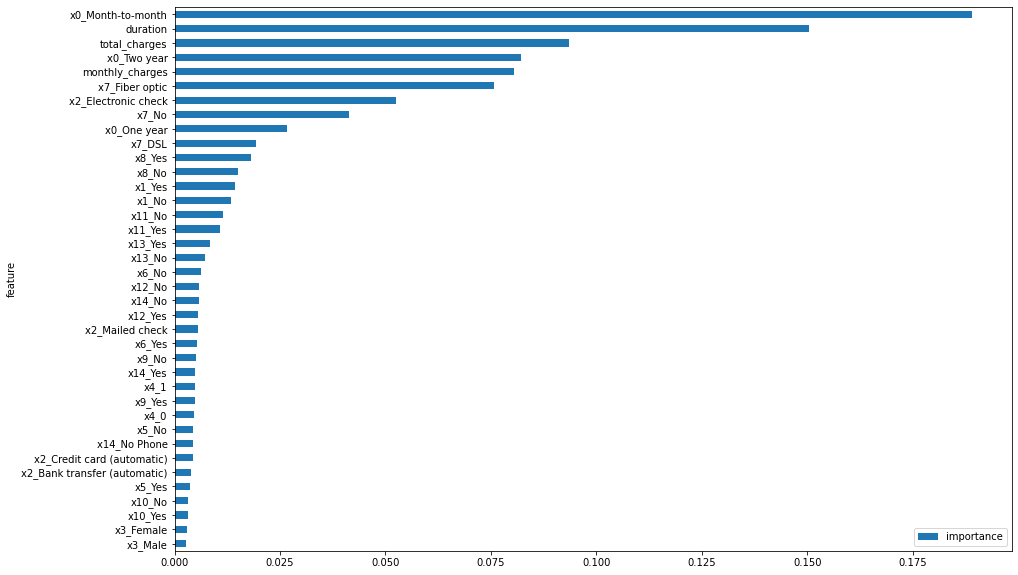

In [388]:
fe = pd.DataFrame({'importance': search_forest_2.best_estimator_['forest'].feature_importances_, 'feature': ct.transformers_[0][2] + list(ct.named_transformers_.categorical.get_feature_names())}).sort_values('importance')
fe.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))

### Часть 3

In [217]:
params_forest_3 = {
    'forest__n_estimators': np.arange(900, 1101, 5),
    'forest__min_samples_split': np.arange(40, 66),
    'forest__min_samples_leaf': np.arange(1, 5)
}

In [218]:
search_forest_3 = GridSearchCV(
    pipe_forest,
    param_grid=params_forest_3,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [219]:
search_forest_3.fit(X_train, y_train)

Fitting 5 folds for each of 4264 candidates, totalling 21320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        Random...
                         'forest__min_samples_split': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 6

In [220]:
(
    pd.DataFrame(search_forest_3.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
125,910,43,1,0.849667,0.902728,0.769438,0.809150
124,905,43,1,0.849662,0.902724,0.769260,0.809194
123,900,43,1,0.849621,0.902727,0.769083,0.809194
127,920,43,1,0.849619,0.902723,0.769261,0.809283
126,915,43,1,0.849612,0.902721,0.769260,0.809460
...,...,...,...,...,...,...,...
4092,1065,61,4,0.848575,0.887876,0.766420,0.795083
4098,1095,61,4,0.848575,0.887846,0.765888,0.795083
4075,980,61,4,0.848573,0.887873,0.766065,0.795349
4099,1100,61,4,0.848549,0.887857,0.765710,0.795128


### Часть 4

In [221]:
params_forest_4 = {
    'forest__n_estimators': np.arange(850, 951, 5),
    'forest__min_samples_split': np.arange(30, 56),
    'forest__min_samples_leaf': np.arange(1, 5)
}

In [222]:
search_forest_4 = GridSearchCV(
    pipe_forest,
    param_grid=params_forest_4,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [223]:
search_forest_4.fit(X_train, y_train)

Fitting 5 folds for each of 2184 candidates, totalling 10920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        Random...
             param_grid={'forest__min_samples_leaf': array([1, 2, 3, 4]),
                         'forest__min_samples_split': array([30, 31, 32, 33

In [224]:
(
    pd.DataFrame(search_forest_4.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
285,910,43,1,0.849667,0.902728,0.769438,0.809150
284,905,43,1,0.849662,0.902724,0.769260,0.809194
280,885,43,1,0.849639,0.902723,0.769260,0.809549
282,895,43,1,0.849639,0.902716,0.769260,0.809327
283,900,43,1,0.849621,0.902727,0.769083,0.809194
...,...,...,...,...,...,...,...
1226,890,36,3,0.848543,0.906773,0.770324,0.813631
1225,885,36,3,0.848540,0.906766,0.770502,0.813587
1221,865,36,3,0.848539,0.906742,0.770324,0.813720
1223,875,36,3,0.848525,0.906747,0.770679,0.813853


### Часть 5

In [225]:
params_forest_5 = {
    'forest__n_estimators': np.arange(900, 920),
    'forest__min_samples_split': np.arange(38, 49),
    'forest__min_samples_leaf': np.arange(1, 4)
}

In [226]:
search_forest_5 = GridSearchCV(
    pipe_forest,
    param_grid=params_forest_5,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [227]:
search_forest_5.fit(X_train, y_train)

Fitting 5 folds for each of 660 candidates, totalling 3300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 3300 out of 3300 | elapsed: 58.0min finished


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        Random...
                                                               n_jobs=-1,
                                                               random_state

In [228]:
(
    pd.DataFrame(search_forest_5.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__min_samples_leaf', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
107,907,43,1,0.849671,0.902728,0.769083,0.809283
109,909,43,1,0.849671,0.902727,0.769438,0.809150
110,910,43,1,0.849667,0.902728,0.769438,0.809150
106,906,43,1,0.849667,0.902721,0.769083,0.809194
105,905,43,1,0.849662,0.902724,0.769260,0.809194
...,...,...,...,...,...,...,...
495,915,40,3,0.848906,0.902816,0.769437,0.809505
480,900,40,3,0.848905,0.902822,0.769437,0.809860
494,914,40,3,0.848902,0.902822,0.769260,0.809460
482,902,40,3,0.848884,0.902818,0.769259,0.809815


### Часть 6

In [233]:
params_forest_6 = {
    'forest__n_estimators': [907],
    'forest__min_samples_split': [43],
    'forest__min_samples_leaf': [1],
    'forest__max_depth': np.arange(1, 31)
}

In [134]:
search_forest_6 = GridSearchCV(
    pipe_forest,
    param_grid=params_forest_6,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [235]:
search_forest_6.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BCD0>),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000200F6B9BE20>)])),
                                       ('forest',
                                        Random...t='balanced',
                                                               n_jobs=-1,
                                                              

In [237]:
(
    pd.DataFrame(search_forest_6.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_forest__max_depth', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
).head(10)

,param_forest__max_depth,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
17,18,0.849729,0.902707,0.769615,0.809238
16,17,0.849694,0.902691,0.769616,0.809061
19,20,0.849683,0.902722,0.769083,0.809371
20,21,0.849682,0.902727,0.769083,0.809283
22,23,0.849677,0.902724,0.769083,0.809283
23,24,0.849671,0.902728,0.769083,0.809283
29,30,0.849671,0.902728,0.769083,0.809283
24,25,0.849671,0.902728,0.769083,0.809283
25,26,0.849671,0.902728,0.769083,0.809283
26,27,0.849671,0.902728,0.769083,0.809283


In [238]:
# Best parameters
search_forest_6.best_params_

{'forest__max_depth': 18,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 43,
 'forest__n_estimators': 907}

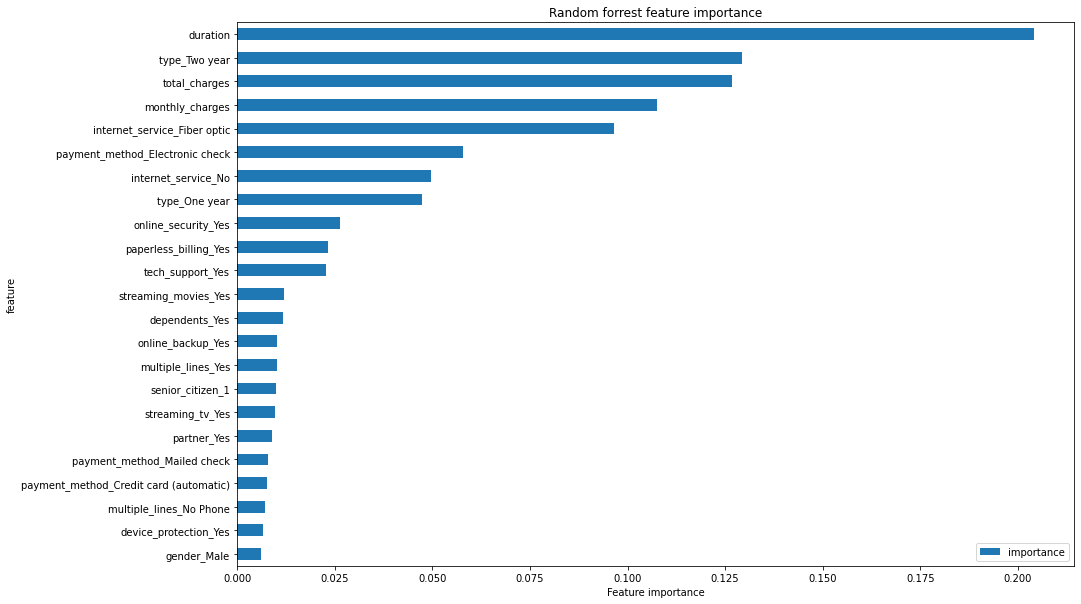

In [136]:
fi = pd.DataFrame({'importance': search_forest_6.best_estimator_['forest'].feature_importances_, 'feature': search_forest_6.best_estimator_.named_steps.transformer.transformers_[0][2] + cat_columns_ohe_names}).sort_values('importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.xlabel('Feature importance')
plt.title('Random forrest feature importance')
plt.show()

## CatBoost

In [83]:
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, thread_count=1)

### Часть 1

In [266]:
params_catboost = {
    'iterations': np.arange(100, 2101, 500),
    'depth':  np.arange(2, 11, 2),
    'l2_leaf_reg': [0.01, 0.1, 1, 3, 5, 7, 10]
}

In [267]:
search_catboost = GridSearchCV(
    catboost,
    param_grid=params_catboost,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [268]:
search_catboost.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 83.2min
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed: 210.1min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x00000200FC0A1AC0>,
             n_jobs=-1,
             param_grid={'depth': array([ 2,  4,  6,  8, 10]),
                         'iterations': array([ 100,  600, 1100, 1600, 2100]),
                         'l2_leaf_reg': [0.01, 0.1, 1, 3, 5, 7, 10]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [273]:
(
    pd.DataFrame(search_catboost.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
8,600,2,0.1,0.863926,0.878577,0.761627,0.776136
7,600,2,0.01,0.863749,0.878278,0.757722,0.773429
10,600,2,3,0.863613,0.878080,0.759675,0.774361
9,600,2,1,0.863568,0.877858,0.759497,0.775337
12,600,2,7,0.863356,0.877695,0.759851,0.773917
...,...,...,...,...,...,...,...
154,1100,10,0.01,0.840632,0.959277,0.802094,0.906594
134,2100,8,0.1,0.840599,0.964144,0.800496,0.911919
147,600,10,0.01,0.840477,0.947402,0.800320,0.891108
168,2100,10,0.01,0.840138,0.962306,0.802803,0.909789


### Часть 2

In [107]:
params_catboost_2 = {
    'iterations': np.arange(100, 1501, 150),
    'depth':  np.arange(1, 7),
    'l2_leaf_reg': [0.01, 0.1, 1, 3, 5, 7, 10]
}

In [108]:
search_catboost_2 = GridSearchCV(
    catboost,
    param_grid=params_catboost_2,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [109]:
search_catboost_2.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 68.9min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000029690B14A30>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5, 6]),
                         'iterations': array([ 100,  250,  400,  550,  700,  850, 1000, 1150, 1300, 1450]),
                         'l2_leaf_reg': [0.01, 0.1, 1, 3, 5, 7, 10]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [123]:
(
    pd.DataFrame(search_catboost_2.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
).head(30)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
218,250,4,0.1,0.864362,0.878909,0.763580,0.777511
92,550,2,0.1,0.863835,0.877901,0.761450,0.775293
91,550,2,0.01,0.863807,0.877595,0.758077,0.773296
99,700,2,0.1,0.863796,0.879769,0.761272,0.777644
101,700,2,3,0.863711,0.879212,0.759675,0.775914
106,850,2,0.1,0.863694,0.881324,0.762692,0.779730
100,700,2,1,0.863688,0.879060,0.760917,0.775914
225,400,4,0.1,0.863680,0.886163,0.766952,0.787540
107,850,2,1,0.863641,0.880533,0.761627,0.777511
159,400,3,7,0.863618,0.878711,0.762336,0.777290


### Часть 3

In [130]:
params_catboost_3 = {
    'iterations': np.arange(200, 901, 50),
    'depth':  np.arange(1, 7),
    'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]
}

In [131]:
search_catboost_3 = GridSearchCV(
    catboost,
    param_grid=params_catboost_3,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [132]:
search_catboost_3.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 67.1min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000029690B14A30>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5, 6]),
                         'iterations': array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,
       850, 900]),
                         'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [251]:
(
    pd.DataFrame(search_catboost_3.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
284,300,4,0.1,0.864487,0.880971,0.764644,0.779952
278,250,4,0.1,0.864362,0.878909,0.763580,0.777511
290,350,4,0.1,0.864187,0.883528,0.764822,0.782614
140,600,2,0.1,0.863926,0.878577,0.761627,0.776136
146,650,2,0.1,0.863911,0.879229,0.761450,0.777334
...,...,...,...,...,...,...,...
516,750,6,0.001,0.850441,0.926561,0.784524,0.844560
535,900,6,0.01,0.850070,0.930224,0.784701,0.850062
522,800,6,0.001,0.849834,0.928698,0.783813,0.846690
528,850,6,0.001,0.848700,0.931020,0.786122,0.850949


### Часть 4

In [256]:
params_catboost_4 = {
    'iterations': np.arange(200, 401, 10),
    'depth':  np.arange(1, 6),
    'l2_leaf_reg': np.arange(0.001, 1, 0.1)
}

In [259]:
search_catboost_4 = GridSearchCV(
    catboost,
    param_grid=params_catboost_4,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [260]:
search_catboost_4.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000029690B14A30>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5]),
                         'iterations': array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400]),
                         'l2_leaf_reg': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901])},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [266]:
(
    pd.DataFrame(search_catboost_4.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
741,310,4,0.101,0.864333,0.881477,0.767662,0.780662
745,310,4,0.501,0.864296,0.881309,0.766064,0.781194
735,300,4,0.501,0.864296,0.880902,0.766420,0.779996
749,310,4,0.901,0.864288,0.880408,0.767307,0.778355
751,320,4,0.101,0.864270,0.881838,0.767129,0.781061
...,...,...,...,...,...,...,...
0,200,1,0.001,0.850871,0.856525,0.740861,0.744586
5,200,1,0.501,0.850787,0.856471,0.741038,0.744986
9,200,1,0.901,0.850765,0.856271,0.740151,0.743743
8,200,1,0.801,0.850655,0.856053,0.742103,0.745119


### Часть 5

In [268]:
params_catboost_5 = {
    'iterations': np.arange(285, 326),
    'depth':  [4],
    'l2_leaf_reg': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [270]:
search_catboost_5 = GridSearchCV(
    catboost,
    param_grid=params_catboost_5,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [271]:
search_catboost_5.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 492 candidates, totalling 2460 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 2460 out of 2460 | elapsed: 41.8min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000029690B14A30>,
             n_jobs=-1,
             param_grid={'depth': [4],
                         'iterations': array([285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
       311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325]),
                         'l2_leaf_reg': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                         0.6, 0.7, 0.8, 0.9, 1]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [272]:
(
    pd.DataFrame(search_catboost_5.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
86,292,4,0.1,0.864519,0.880611,0.765354,0.779863
98,293,4,0.1,0.864502,0.880669,0.764644,0.779730
122,295,4,0.1,0.864501,0.880742,0.764822,0.779863
110,294,4,0.1,0.864498,0.880705,0.764467,0.779641
194,301,4,0.1,0.864487,0.881010,0.764999,0.779908
...,...,...,...,...,...,...,...
306,310,4,0.5,0.862668,0.881150,0.766597,0.780573
408,319,4,0.01,0.862648,0.882302,0.765532,0.781683
396,318,4,0.01,0.862633,0.882278,0.765354,0.781638
372,316,4,0.01,0.862627,0.882123,0.765177,0.781816


### Часть 6

In [279]:
params_catboost_6 = {
    'iterations': [292],
    'depth':  [4],
    'l2_leaf_reg': np.arange(0.02, 0.2, 0.01)
}

In [138]:
search_catboost_6 = GridSearchCV(
    catboost,
    param_grid=params_catboost_6,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [281]:
search_catboost_6.fit(X_train, y_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000029690B14A30>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': [292],
                         'l2_leaf_reg': array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [282]:
(
    pd.DataFrame(search_catboost_6.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
8,292,4,0.1,0.864519,0.880611,0.765354,0.779863
2,292,4,0.04,0.864204,0.881023,0.766065,0.779419
12,292,4,0.14,0.864135,0.880658,0.766064,0.777955
9,292,4,0.11,0.864116,0.880471,0.765532,0.779286
11,292,4,0.13,0.864056,0.880431,0.764467,0.778443
14,292,4,0.16,0.864002,0.880278,0.765888,0.777334
3,292,4,0.05,0.863952,0.881106,0.765533,0.779375
10,292,4,0.12,0.863890,0.880577,0.766242,0.779730
15,292,4,0.17,0.863623,0.880479,0.766775,0.779286
4,292,4,0.06,0.863579,0.880217,0.764823,0.778044


In [283]:
# Best parameters
search_catboost_6.best_params_

{'depth': 4, 'iterations': 292, 'l2_leaf_reg': 0.09999999999999999}

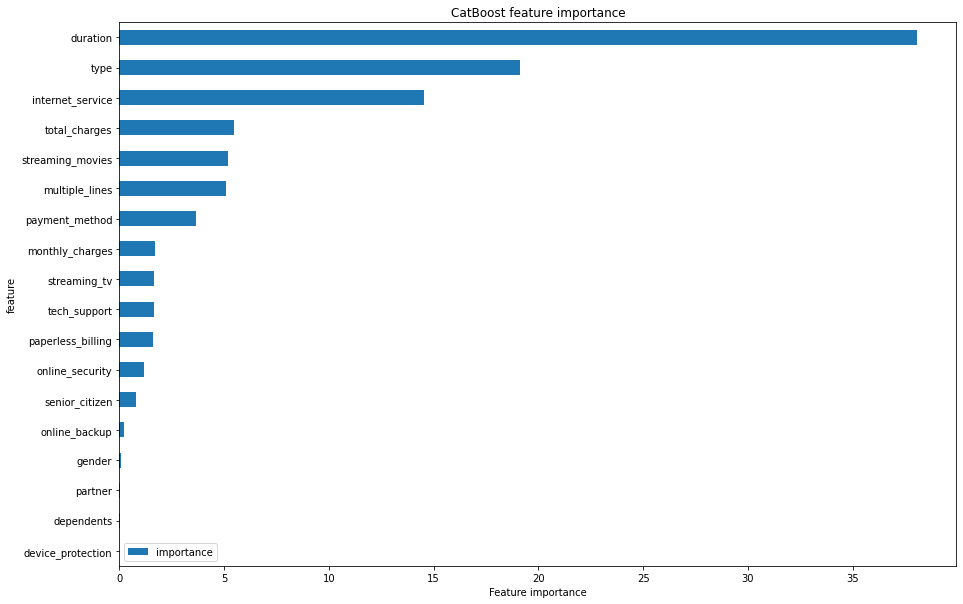

In [140]:
fi = pd.DataFrame({'importance': search_catboost_6.best_estimator_.feature_importances_, 'feature': search_catboost_6.best_estimator_.feature_names_}).sort_values(by='importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.xlabel('Feature importance')
plt.title('CatBoost feature importance')
plt.show()

### Часть 7

In [96]:
X_train.drop(columns=['partner', 'dependents', 'device_protection']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5634 non-null   category
 1   paperless_billing  5634 non-null   category
 2   payment_method     5634 non-null   category
 3   monthly_charges    5634 non-null   float64 
 4   total_charges      5634 non-null   float64 
 5   duration           5634 non-null   int64   
 6   gender             5634 non-null   category
 7   senior_citizen     5634 non-null   category
 8   internet_service   5634 non-null   category
 9   online_security    5634 non-null   category
 10  online_backup      5634 non-null   category
 11  tech_support       5634 non-null   category
 12  streaming_tv       5634 non-null   category
 13  streaming_movies   5634 non-null   category
 14  multiple_lines     5634 non-null   category
dtypes: category(12), float64(2), int64(1)
memory usage: 2

In [105]:
params_catboost_7 = {
    'iterations': np.arange(200, 901, 50),
    'depth':  np.arange(1, 7),
    'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]
}

In [106]:
search_catboost_7 = GridSearchCV(
    catboost,
    param_grid=params_catboost_7,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [107]:
search_catboost_7.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 51.1min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fe4bc98e6d0>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5, 6]),
                         'iterations': array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,
       850, 900]),
                         'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [108]:
(
    pd.DataFrame(search_catboost_7.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
268,900,3,3,0.855781,0.882133,0.757012,0.780751
333,700,4,1,0.855664,0.891816,0.759319,0.791578
262,850,3,3,0.855622,0.880886,0.757900,0.780041
256,800,3,3,0.855580,0.879547,0.756834,0.778976
269,900,3,5,0.855577,0.880900,0.755060,0.778399
...,...,...,...,...,...,...,...
5,200,1,5,0.842391,0.844233,0.735535,0.736333
3,200,1,1,0.842360,0.844228,0.739795,0.740105
0,200,1,0.001,0.842288,0.844623,0.737842,0.738463
1,200,1,0.01,0.842137,0.844323,0.736778,0.738152


### Часть 8

In [110]:
params_catboost_8 = {
    'iterations': np.arange(950, 1501, 50),
    'depth':  np.arange(1, 7),
    'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]
}

In [111]:
search_catboost_8 = GridSearchCV(
    catboost,
    param_grid=params_catboost_8,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [112]:
search_catboost_8.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 90.3min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fe4bc98e6d0>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5, 6]),
                         'iterations': array([ 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450,
       1500]),
                         'l2_leaf_reg': [0.001, 0.01, 0.1, 1, 3, 5]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [113]:
(
    pd.DataFrame(search_catboost_8.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
161,1050,3,5,0.855679,0.884252,0.757367,0.781993
191,1300,3,5,0.855667,0.889030,0.759142,0.786963
173,1150,3,5,0.855642,0.886268,0.756835,0.784833
143,1500,2,5,0.855625,0.876899,0.757899,0.774183
149,950,3,5,0.855620,0.882080,0.755947,0.779641
...,...,...,...,...,...,...,...
427,1500,6,0.01,0.838288,0.984259,0.782392,0.927494
408,1350,6,0.001,0.838239,0.982493,0.780619,0.927227
414,1400,6,0.001,0.837964,0.983623,0.780796,0.930200
420,1450,6,0.001,0.837109,0.984889,0.783104,0.933795


### Часть 9

In [115]:
params_catboost_9 = {
    'iterations': np.arange(950, 1401, 50),
    'depth':  np.arange(1, 6),
    'l2_leaf_reg': [7, 10, 15, 20, 30]
}

In [116]:
search_catboost_9 = GridSearchCV(
    catboost,
    param_grid=params_catboost_9,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [117]:
search_catboost_9.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 43.4min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fe4bc98e6d0>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4, 5]),
                         'iterations': array([ 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400]),
                         'l2_leaf_reg': [7, 10, 15, 20, 30]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [118]:
(
    pd.DataFrame(search_catboost_9.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
81,1250,2,10,0.855295,0.873321,0.755414,0.771565
86,1300,2,10,0.855290,0.873885,0.755059,0.771831
110,1050,3,7,0.855288,0.882714,0.757367,0.781283
76,1200,2,10,0.855247,0.872786,0.755947,0.770988
71,1150,2,10,0.855237,0.872251,0.754704,0.770678
...,...,...,...,...,...,...,...
225,1200,5,7,0.851745,0.915461,0.768017,0.819267
230,1250,5,7,0.851503,0.916998,0.768372,0.821131
235,1300,5,7,0.851292,0.918625,0.768195,0.822639
240,1350,5,7,0.850987,0.920035,0.768549,0.823837


### Часть 10

In [119]:
params_catboost_10 = {
    'iterations': np.arange(1150, 1351, 10),
    'depth':  np.arange(1, 5),
    'l2_leaf_reg': [7, 8, 9, 10, 11, 12, 13]
}

In [120]:
search_catboost_10 = GridSearchCV(
    catboost,
    param_grid=params_catboost_10,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [121]:
search_catboost_10.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 97.9min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fe4bc98e6d0>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4]),
                         'iterations': array([1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250,
       1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350]),
                         'l2_leaf_reg': [7, 8, 9, 10, 11, 12, 13]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [122]:
(
    pd.DataFrame(search_catboost_10.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
298,1150,3,11,0.855628,0.883151,0.758432,0.783014
305,1160,3,11,0.855573,0.883384,0.758609,0.783147
326,1190,3,11,0.855527,0.883884,0.758609,0.783458
333,1200,3,11,0.855524,0.884062,0.758609,0.783635
312,1170,3,11,0.855518,0.883544,0.758609,0.783280
...,...,...,...,...,...,...,...
560,1320,4,7,0.853623,0.903564,0.761805,0.804535
553,1310,4,7,0.853599,0.903305,0.761449,0.804446
567,1330,4,7,0.853582,0.903813,0.761450,0.804668
574,1340,4,7,0.853546,0.904002,0.761627,0.805289


### Часть 11

In [84]:
params_catboost_11 = {
    'iterations': np.arange(700, 1100, 10),
    'depth':  np.arange(1, 5),
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 13]
}

In [85]:
search_catboost_11 = GridSearchCV(
    catboost,
    param_grid=params_catboost_11,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [86]:
search_catboost_11.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 54.5min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fb7c3b30d90>,
             n_jobs=-1,
             param_grid={'depth': array([1, 2, 3, 4]),
                         'iterations': array([ 700,  710,  720,  730,  740,  750,  760,  770,  780,  790,  800,
        810,  820,  830,  840,  850,  860,  870,  880,  890,  900,  910,
        920,  930,  940,  950,  960,  970,  980,  990, 1000, 1010, 1020,
       1030, 1040, 1050, 1060, 1070, 1080, 1090]),
                         'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 13]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [87]:
(
    pd.DataFrame(search_catboost_11.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
789,1020,3,11,0.855879,0.880694,0.758608,0.779996
796,1030,3,11,0.855870,0.880934,0.758964,0.780484
782,1010,3,11,0.855861,0.880546,0.758964,0.779730
803,1040,3,11,0.855846,0.881097,0.758609,0.780618
810,1050,3,11,0.855837,0.881219,0.758431,0.780751
...,...,...,...,...,...,...,...
10,710,1,7,0.852973,0.858219,0.746007,0.752574
0,700,1,1,0.852938,0.858290,0.746895,0.753505
11,710,1,9,0.852934,0.858162,0.746185,0.752352
3,700,1,7,0.852914,0.858138,0.745475,0.752352


### Часть 12

In [90]:
params_catboost_12 = {
    'iterations': np.arange(1010, 1031),
    'depth':  [3],
    'l2_leaf_reg': [10, 10.5, 11, 11.5, 12]
}

In [92]:
search_catboost_12 = GridSearchCV(
    catboost,
    param_grid=params_catboost_12,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=4,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [93]:
search_catboost_12.fit(X_train.drop(columns=['partner', 'dependents', 'device_protection']), y_train, cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=0)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 525 out of 525 | elapsed: 15.6min finished


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fb7c3b30d90>,
             n_jobs=4,
             param_grid={'depth': [3],
                         'iterations': array([1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030]),
                         'l2_leaf_reg': [10, 10.5, 11, 11.5, 12]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [94]:
(
    pd.DataFrame(search_catboost_12.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_iterations', 'param_depth', 'param_l2_leaf_reg', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_iterations,param_depth,param_l2_leaf_reg,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
82,1026,3,11,0.855918,0.880849,0.758963,0.780351
77,1025,3,11,0.855902,0.880831,0.759319,0.780129
57,1021,3,11,0.855901,0.880709,0.758964,0.780041
62,1022,3,11,0.855900,0.880736,0.758608,0.779996
72,1024,3,11,0.855891,0.880787,0.758963,0.779996
...,...,...,...,...,...,...,...
61,1022,3,10.5,0.854804,0.880257,0.756302,0.778488
66,1023,3,10.5,0.854801,0.880272,0.756125,0.778532
86,1027,3,10.5,0.854795,0.880382,0.755770,0.778355
76,1025,3,10.5,0.854792,0.880333,0.755770,0.778532


## VotingClassifier

In [97]:
pipe_logreg = Pipeline([
    ('transformer', ct),
    ('regression', LogisticRegression(C=161.51326935030897, max_iter=200, class_weight='balanced', random_state=42, n_jobs=1))
])

pipe_tree = Pipeline([
    ('transformer', ct),
    ('tree', DecisionTreeClassifier(max_depth=9, min_samples_leaf=51, min_samples_split=187, class_weight='balanced', random_state=42))
])

pipe_forest = Pipeline([
    ('transformer', ct),
    ('forest', RandomForestClassifier(n_estimators=907, max_depth=18, min_samples_split=43, class_weight='balanced', random_state=42, n_jobs=-1))
])

catboost_vc = CatBoostClassifier(iterations=292, depth=4, l2_leaf_reg=0.1, auto_class_weights='Balanced', random_state=42, thread_count=1, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

In [98]:
estimators=[('lr', pipe_logreg), ('tr', pipe_tree), ('fr', pipe_forest), ('bst', catboost_vc)]

In [99]:
vc = VotingClassifier(estimators=estimators, voting='soft')

### Часть 1

In [426]:
# random weights
weights = []
for i in range(100):
    weights.append(list(np.random.dirichlet(np.ones(4), size=1)[0]))

In [427]:
params_vc = {
    'weights': weights
}

In [428]:
search_vc = GridSearchCV(
    vc,
    param_grid=params_vc,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [429]:
search_vc.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.5min finished


GridSearchCV(estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('transformer',
                                                                      ColumnTransformer(transformers=[('numerical',
                                                                                                       StandardScaler(),
                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x00000296A0255EE0>),
                                                                                                      ('categorical',
                                                                                                       OneHotEncoder(drop='first'),
                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [433]:
(
    pd.DataFrame(search_vc.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_weights', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_weights,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
88,"[0.17635432952728772, 0.13218381833788934, 0.0...",0.864119,0.879990,0.763934,0.776225
94,"[0.04185692053899253, 0.0027281113667365527, 0...",0.864107,0.885074,0.766419,0.782614
70,"[0.15863026724078833, 0.05935873315726213, 0.1...",0.863842,0.882180,0.765709,0.778887
33,"[0.053306774302978886, 0.10130470127436116, 0....",0.863833,0.885596,0.765887,0.782881
30,"[0.19856105381248304, 0.0991605554261495, 0.05...",0.863815,0.880301,0.764289,0.776801
...,...,...,...,...,...
91,"[0.5400873067424331, 0.01912915056107748, 0.35...",0.852292,0.875676,0.759852,0.774849
46,"[0.5999554681799223, 0.15207785911670643, 0.24...",0.851580,0.870863,0.756303,0.769169
72,"[0.5339888959658177, 0.007451251688265488, 0.3...",0.851522,0.876510,0.760207,0.776003
52,"[0.8036568980379839, 0.016571763319328206, 0.0...",0.851028,0.858752,0.749381,0.756523


In [435]:
(
    pd.DataFrame(search_vc.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_weights', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
).head().values

array([[list([0.17635432952728772, 0.13218381833788934, 0.03183585225880386, 0.659625999876019]),
        0.8641194039657041, 0.8799900798489995, 0.7639338629883957,
        0.776224640404584],
       [list([0.04185692053899253, 0.0027281113667365527, 0.14983939276003624, 0.8055755753342346]),
        0.8641072857316987, 0.885074297959125, 0.7664191230589077,
        0.7826144837499156],
       [list([0.15863026724078833, 0.05935873315726213, 0.10323127453415439, 0.6787797250677953]),
        0.8638423718579267, 0.8821802280910246, 0.76570880108936,
        0.7788870078664973],
       [list([0.053306774302978886, 0.10130470127436116, 0.15920057440248916, 0.6861879500201709]),
        0.8638333835330861, 0.8855961648888023, 0.7658865785869525,
        0.7828807756208473],
       [list([0.19856105381248304, 0.0991605554261495, 0.05959074505213785, 0.6426876457092295]),
        0.8638149230355442, 0.8803012860858603, 0.7642887875669228,
        0.7768014715943197]], dtype=object)

### Часть 2

In [100]:
# defined weights
params_vc_2 = {
    'weights': [
        [0.01, 0.01, 0.01, 0.97],
        [0.01, 0.01, 0.02, 0.96],
        [0.01, 0.02, 0.02, 0.95],
        [0.02, 0.02, 0.02, 0.94],
        [0.02, 0.02, 0.03, 0.93],
        [0.02, 0.03, 0.03, 0.92],
        [0.03, 0.03, 0.03, 0.91]
    ]
}

In [101]:
search_vc_2 = GridSearchCV(
    vc,
    param_grid=params_vc_2,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [102]:
search_vc_2.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.9min finished


GridSearchCV(estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('transformer',
                                                                      ColumnTransformer(transformers=[('numerical',
                                                                                                       StandardScaler(),
                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7fb7c227fe50>),
                                                                                                      ('categorical',
                                                                                                       OneHotEncoder(drop='first'),
                                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7fb7c22

In [103]:
(
    pd.DataFrame(search_vc_2.cv_results_)
    .sort_values('mean_test_roc_auc', ascending=False)
    [['param_weights', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']]
)

,param_weights,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
3,"[0.02, 0.02, 0.02, 0.94]",0.864697,0.881293,0.766241,0.779863
5,"[0.02, 0.03, 0.03, 0.92]",0.864679,0.881708,0.765709,0.779819
4,"[0.02, 0.02, 0.03, 0.93]",0.864664,0.881629,0.766064,0.780129
6,"[0.03, 0.03, 0.03, 0.91]",0.864655,0.881602,0.765531,0.779641
2,"[0.01, 0.02, 0.02, 0.95]",0.864643,0.881394,0.765531,0.779996
1,"[0.01, 0.01, 0.02, 0.96]",0.864603,0.881307,0.765531,0.779996
0,"[0.01, 0.01, 0.01, 0.97]",0.864594,0.880966,0.765354,0.779863


# Проверка лучшей модели на тестовой выборке

In [259]:
print('ROC AUC with best model on test sample - {:.3f}, accuracy - {:.3f}'.format(
    roc_auc_score(y_true=y_test, y_score=search_vc_2.predict_proba(X_test)[:, 1]),
    accuracy_score(y_true=y_test, y_pred=search_vc_2.predict(X_test))
))

ROC AUC with best model on test sample - 0.881, accuracy - 0.782


In [260]:
# overfitting test
print('ROC AUC with best model on train sample - {:.3f}, accuracy - {:.3f}'.format(
    roc_auc_score(y_true=y_train, y_score=search_vc_2.predict_proba(X_train)[:, 1]),
    accuracy_score(y_true=y_train, y_pred=search_vc_2.predict(X_train))
))

ROC AUC with best model on train sample - 0.879, accuracy - 0.775


# Общие выводы

В ходе выбора лучшей модели оптимизировались гиперпараметры у 5 моделей:
1. Логистическая регрессия (ROC AUC - 0.844, accuracy - 0.742);
2. Дерево решений (ROC AUC - 0.846, accuracy - 0.744);
3. Случайный лес (ROC AUC - 0.850, accuracy - 0.770);
4. CatBoost (ROC AUC - 0.8645, accuracy - 0.764);
5. VotingClassifier (ROC AUC - 0.8647, accuracy - 0.765), который совместил в себе все предыдущие модели путем "мягкого" взвешенного голосования и получил лучшие результаты по основной метрике ROC AUC и второй результат по дополнительной метрике accuracy.

Важно отметить, что отрыв от CatBoost у VotingClassifier минимален, и если компании важна скорость работы, а не доли процентов в качестве, то стоит обратить внимание на CatBoost.

Лучшая модель была протестирована на тестовой выборке (20% от все выборки). ROC AUC составил 0.881, а accuracy 0.775, что является достаточно хорошим результатом, вполне удовлетворяющим поставленную задачу. Переобучение модели отсутствует как таковое.

# Отчет

## Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана выполнены.

## Какие трудности возникли и как вы их преодолели?

Никаких трудностей не возникло.

## Какие ключевые шаги в решении задачи выделили?

1. EDA;
2. Feature engineering;
2. Извлечение ключевого признака;
3. Уточнение задачи;
4. Составление плана решения задачи;
5. Оптимизация гиперпараметров моделей;
6. Тестирование лучшей модели;
7. Написание вывода по работе.

## Какая ваша итоговая модель и какое у неё качество?

"Мягкий" взвешенный VotingClassifier, объединяющий логистическую регрессию, дерево решений, случайный лес и CatBoost, с весами [0.02, 0.02, 0.02, 0.94], соответственно. ROC AUC составил 0.881, а accuracy 0.775.